Reading time: 10 minutes

In [ ]:
# --------------- IMPORTS --------------------

import os
import time
import psutil
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal.windows import hamming, tukey
from scipy.signal import butter, filtfilt, sosfiltfilt
from statistics import mean
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from multiprocessing import SimpleQueue, Process
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import stack
import tensorflow as tf
from scipy.signal import spectrogram
from skimage.transform import resize
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
# --------------- CONFIG --------------------

# Data loading paths
DATA_PATH = '../input/g2net-gravitational-wave-detection/train'
submission_data_path = '../input/g2net-gravitational-wave-detection/test'
labels_path = '../input/g2net-gravitational-wave-detection/training_labels.csv'

# Parameters
batch_size = 200
learning_rate = 1e-4
epochs = 1

# Constants
INPUT_DIM = (150, 150, 3)
SAMPLE_RATE = 2048

# About the project 

### Objective of the analysis

To sum up, this competition tasks us to operate a binary classification where given a signal, we are to predict if a gravitational wave is in there or not. 

I am not going to show basic EDA for this dataset, as it has already been presented in various notebooks. However, I will still mention that we are given a dataset with two very important characteristics. It has a lot of elements, and both classes are balanced. We can say it fulfills the requirements of both volume and balance, which are precisely the weaknesses I had to work on with previous datasets I have studied on Kaggle. 

What is missing then ?  Well in a word, quality. This analysis was indeed very instructive about the importance of understanding the data and preprocessing it correctly in order to make the most out of it. Which is not something I did from the start ! I made the mistake of going straight for the search of algorithms to treat the problem, without giving a proper thought about the data. As you will see, this mistake did cost me a lot of time.

### Sources

Overall analysis by Laura Fink in her very detailed notebook. This was clearly a lifesaver in my case, as I struggled with finding ways to start going into signal analysis. All the basics can be find there as well as instructive links to understand the data.
https://www.kaggle.com/code/allunia/signal-where-are-you

The competition corresponding paper link : https://arxiv.org/pdf/1908.11170.pdf

Another very complete notebook by Geir Drange whose approach of the data analysis inspired me greatly. It was also a nice way to discover about the wavelet transform.
https://www.kaggle.com/code/mistag/wavelet1d-custom-keras-wavelet-transform-layer

About signal analysis, I ended up watching the excellent series of Steve Brunton on Fourier Analysis. His YouTube channel is a gold mine on this topic.
https://www.youtube.com/c/Eigensteve

On a more technical note, I discovered Keras with « Deep Learning with Python » by François Chollet. In this book I learnt about data generators, which were until recently the only way I knew to load vast amounts of data that cannot fit all at once in memory for training models. But in the very good notebook by Esrat Maria I saw a Tensorflow Dataset pipeline and while searching about it, I found it a very useful tool for our problem.
https://www.kaggle.com/code/esratmaria/gravitational-wave-detection-simple-cnn-model

A nice tutorial about Tensorflow data pipeline: https://youtube.com/watch?v=VFEOskzhhbc


### Sections presentation

We are all set !

In this article I will first present my many mistakes going into the analysis. As Yoda said « The greatest teacher, failure is » (what’s a science topic article without a nerd reference right ?).

That being said, I then proceed to present a more solide approach based on the various sources listed above. Briefly, it uses Fourier transforms to interpret signals as an RGB image where each channel is a detector spectrogram. 

Finally, I try to improve preprocessing further in order to obtain better results mostly by changing a few choices made in the previous section.

# From zero to her… zero !

Last chance for you to skip ahead, this part of the article is not for soft eyes, you are warned ! More seriously you should actually skip that part if you only want to know about working approaches, this really is a « what not to do » section.

### Zero preprocessing - brut force tries on raw data

I did warn you, this is not pretty. My first attempt was exactly as the title announces it: I took the raw signal, and shove it through various types of networks to see what happens. Silly right ? I was even showing perseverance as I tried almost every type of networks I know about. Dense network, CNN, LSTM, Gradient Boosting, Random Forest, SVM… No happy ending here, as you expect it gave a fantastic result of 50% accuracy. When all your work is worth as much as a coin flip, it should be a sign don’t you think ?

Spoiler alert, combining multiple types of networks with stacking did not help either. So much time designing complex blocs of machine learning, with no improvement whatsoever.

### Features extraction

Denile ! At this point it is the only word that accurately describes my thought process. I started to realize that the problem was maybe residing with the way I handled the data, and not the way I handled models and training. Sadly I went in the wrong direction again, keeping the raw signal, and making additional features out of it.

Features extracted for each detector were the following:
* Frequencies
* First degree differentiate
* Curve similarity with other detectors
* Spectrum

Yet even when treated individually or combined together in a single complex model, no results.

*-- features generator code below --*

In [ ]:
# --------------- UTILS --------------------

# Transform signal from time domain to frequency domain
def time_to_frequency(signal, sample_rate):
    n = len(signal)
    yf = fft(signal)
    yf = 2.0/n * np.abs(yf[0:n//2])
    # xf = fftfreq(n, sample_rate)[:n//2]
    return yf


# Transform signal from time series to spectrum image
def time_to_spectrum(signal_npy, sample_rate):
    f, t, Sxx = signal.spectrogram(signal_npy, sample_rate)
    return f, t, Sxx


# Numerical differentiation
def numerical_differentiation(signal: np.array):
    n = len(signal)
    differentiated_signal = signal[1:] - signal[:(n-1)]
    return differentiated_signal


# --------------- CUSTOM GENERATOR --------------------

class CustomGenerator:

    from tensorflow.python.keras.utils.data_utils import Sequence

    def __init__(self, inputs_path: list, labels: list, batch_size: int, input_size: tuple, scalers: dict,
                 model_class: str, shuffle=True):
        self.generator = self.Generator(inputs_path, labels, batch_size, input_size, scalers, model_class, shuffle)

    class Generator(Sequence):

        def __init__(self, inputs_path: list, labels: list, batch_size: int, input_size: tuple, scalers: dict,
                     model_class: str, shuffle=True):

            self.inputs_path = inputs_path
            self.labels = np.asarray(labels, dtype=int)
            self.batch_size = batch_size
            self.input_size = input_size
            self.shuffle = shuffle
            self.nb_inputs = len(inputs_path)
            self.categories = len(np.unique(self.labels))
            self.scalers = scalers
            self.model_class = model_class
            self.n = 0
            self.max = self.__len__()

        def on_epoch_end(self):
            if self.shuffle:
                np.random.shuffle(self.inputs_path)

        def _yield_ish(self, index):
            X_path = self.inputs_path[index * self.batch_size: (index + 1) * self.batch_size]
            inputs = {
                'detector_1_time_input': [],
                'detector_2_time_input': [],
                'detector_3_time_input': [],
                'detector_1_frequency_input': [],
                'detector_2_frequency_input': [],
                'detector_3_frequency_input': [],
                'detector_1_time_differentiate_input': [],
                'detector_2_time_differentiate_input': [],
                'detector_3_time_differentiate_input': [],
                'detector_1_2_similarity_input': [],
                'detector_1_3_similarity_input': [],
                'detector_2_3_similarity_input': [],
                'detectors_time_input': []
            }
            for path in X_path:
                # load the numpy arrays into memory
                data = np.load(path)
                
                # enrich and preprocess the data
                if self.model_class == 'dcb':
                    time_inputs, frequency_inputs, time_differentiate_inputs, similarity_inputs = self.preprocess(data)
                    inputs['detector_1_time_input'].append(time_inputs[0])
                    inputs['detector_2_time_input'].append(time_inputs[1])
                    inputs['detector_3_time_input'].append(time_inputs[2])
                    inputs['detector_1_frequency_input'].append(frequency_inputs[0])
                    inputs['detector_2_frequency_input'].append(frequency_inputs[1])
                    inputs['detector_3_frequency_input'].append(frequency_inputs[2])
                    inputs['detector_1_time_differentiate_input'].append(time_differentiate_inputs[0])
                    inputs['detector_2_time_differentiate_input'].append(time_differentiate_inputs[1])
                    inputs['detector_3_time_differentiate_input'].append(time_differentiate_inputs[2])
                    inputs['detector_1_2_similarity_input'].append(similarity_inputs[0])
                    inputs['detector_1_3_similarity_input'].append(similarity_inputs[1])
                    inputs['detector_2_3_similarity_input'].append(similarity_inputs[2])
                elif self.model_class == 'ccb':
                    time_inputs, frequency_inputs, time_differentiate_inputs, similarity_inputs = self.preprocess(data)
                    inputs['detector_1_time_input'].append(np.transpose(time_inputs[0]))
                    inputs['detector_2_time_input'].append(np.transpose(time_inputs[1]))
                    inputs['detector_3_time_input'].append(np.transpose(time_inputs[2]))
                    inputs['detector_1_frequency_input'].append(np.transpose(frequency_inputs[0]))
                    inputs['detector_2_frequency_input'].append(np.transpose(frequency_inputs[1]))
                    inputs['detector_3_frequency_input'].append(np.transpose(frequency_inputs[2]))
                    inputs['detector_1_time_differentiate_input'].append(np.transpose(time_differentiate_inputs[0]))
                    inputs['detector_2_time_differentiate_input'].append(np.transpose(time_differentiate_inputs[1]))
                    inputs['detector_3_time_differentiate_input'].append(np.transpose(time_differentiate_inputs[2]))
                    inputs['detector_1_2_similarity_input'].append(np.transpose(similarity_inputs[0]))
                    inputs['detector_1_3_similarity_input'].append(np.transpose(similarity_inputs[1]))
                    inputs['detector_2_3_similarity_input'].append(np.transpose(similarity_inputs[2]))
                    inputs['detectors_time_input'].append(np.transpose(np.array([
                        np.squeeze(time_inputs[0]),
                        np.squeeze(time_inputs[1]),
                        np.squeeze(time_inputs[2])
                    ])))

            # convert all inputs to numpy arrays
            for key, array in inputs.items():
                inputs[key] = np.asarray(array, dtype='float64')

            return inputs

        def __getitem__(self, index):
            label = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
            inputs = self._yield_ish(index)
            return inputs, label

        def __len__(self):
            return self.nb_inputs // self.batch_size

        def preprocess(self, data):

            # Get each detector time domain vector
            detector_1_input_time_vector = np.asarray(data[0])
            detector_2_input_time_vector = np.asarray(data[1])
            detector_3_input_time_vector = np.asarray(data[2])

            # Convert time vectors to frequency domain
            detector_1_input_frequency_vector = time_to_frequency(detector_1_input_time_vector, SAMPLE_RATE)
            detector_2_input_frequency_vector = time_to_frequency(detector_2_input_time_vector, SAMPLE_RATE)
            detector_3_input_frequency_vector = time_to_frequency(detector_3_input_time_vector, SAMPLE_RATE)

            # Calculate time first degree differentiate
            detector_1_time_differentiate_vector = numerical_differentiation(detector_1_input_time_vector)
            detector_2_time_differentiate_vector = numerical_differentiation(detector_2_input_time_vector)
            detector_3_time_differentiate_vector = numerical_differentiation(detector_3_input_time_vector)

            # Calculate similarity vectors
            detector_1_2_similarity_vector = detector_1_input_time_vector - detector_2_input_time_vector
            detector_1_3_similarity_vector = detector_1_input_time_vector - detector_3_input_time_vector
            detector_2_3_similarity_vector = detector_2_input_time_vector - detector_3_input_time_vector

            # Normalize time domain vectors
            detector_1_input_time_vector_scaled = self.scalers["time_domain"][0].transform(
                detector_1_input_time_vector.reshape(1, -1))
            detector_2_input_time_vector_scaled = self.scalers["time_domain"][1].transform(
                detector_2_input_time_vector.reshape(1, -1))
            detector_3_input_time_vector_scaled = self.scalers["time_domain"][2].transform(
                detector_3_input_time_vector.reshape(1, -1))
            time_vector_scaled_tuple = (
                detector_1_input_time_vector_scaled.reshape(1, -1),
                detector_2_input_time_vector_scaled.reshape(1, -1),
                detector_3_input_time_vector_scaled.reshape(1, -1)
            )

            # Normalize frequency domain vectors
            detector_1_input_frequency_vector_scaled = self.scalers["frequency_domain"][0].transform(
                detector_1_input_frequency_vector.reshape(1, -1))
            detector_2_input_frequency_vector_scaled = self.scalers["frequency_domain"][1].transform(
                detector_2_input_frequency_vector.reshape(1, -1))
            detector_3_input_frequency_vector_scaled = self.scalers["frequency_domain"][2].transform(
                detector_3_input_frequency_vector.reshape(1, -1))
            frequency_vector_scaled_tuple = (
                detector_1_input_frequency_vector_scaled.reshape(1, -1),
                detector_2_input_frequency_vector_scaled.reshape(1, -1),
                detector_3_input_frequency_vector_scaled.reshape(1, -1)
            )

            # Normalize differentiated curve
            detector_1_time_differentiate_vector_scaled = self.scalers["time_differentiate"][0].transform(
                detector_1_time_differentiate_vector.reshape(1, -1))
            detector_2_time_differentiate_vector_scaled = self.scalers["time_differentiate"][1].transform(
                detector_2_time_differentiate_vector.reshape(1, -1))
            detector_3_time_differentiate_vector_scaled = self.scalers["time_differentiate"][2].transform(
                detector_3_time_differentiate_vector.reshape(1, -1))
            time_differentiate_scaled_tuple = (
                detector_1_time_differentiate_vector_scaled.reshape(1, -1),
                detector_2_time_differentiate_vector_scaled.reshape(1, -1),
                detector_3_time_differentiate_vector_scaled.reshape(1, -1)
            )

            # Normalize similarity curve
            detector_1_2_similarity_vector_scaled = self.scalers['similarity'][0].transform(
                detector_1_2_similarity_vector.reshape(1, -1))
            detector_1_3_similarity_vector_scaled = self.scalers['similarity'][1].transform(
                detector_1_3_similarity_vector.reshape(1, -1))
            detector_2_3_similarity_vector_scaled = self.scalers['similarity'][2].transform(
                detector_2_3_similarity_vector.reshape(1, -1))
            similarity_scaled_tuple = (
                detector_1_2_similarity_vector_scaled.reshape(1, -1),
                detector_1_3_similarity_vector_scaled.reshape(1, -1),
                detector_2_3_similarity_vector_scaled.reshape(1, -1)
            )

            return time_vector_scaled_tuple, frequency_vector_scaled_tuple, time_differentiate_scaled_tuple, similarity_scaled_tuple

        def __next__(self):
            if self.n >= self.max:
                self.n = 0
            result = self.__getitem__(self.n)
            self.n += 1
            return result

### Technical challenge - multiprocessing

Maybe the second most useful takeout of this misery, it was rather instructive to implement multiprocessing like this, it still may be a good tool to have in future work. 

In [ ]:
# Multiprocess functions

def multiprocess_functions(combinations: list, kwargs: dict):
    active_process_count = 0
    queue = SimpleQueue()
    processes = []
    results = []
    while len(combinations) > 0 or len(processes) > 0:
        if not queue.empty():
            combination, history, process_pid = queue.get()
            results.append((combination, history))
            processes.remove(process_pid)
            try:
                process = psutil.Process(process_pid)
                process.kill()
            except psutil.NoSuchProcess as nsp:
                continue
            active_process_count -= 1
        if len(combinations) > 0 and active_process_count < simultaneous_processes_limit:
            combination = combinations.pop(0)
            process = CustomProcess(queue, kwargs, combination)
            process.start()
            active_process_count += 1
            processes.append(process.pid)
    return results

**Needless to say that all these approaches failed, as I missed the most important element in the dataset description: « Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal ».**

# Understand the data

Somehow I forgot that documentation steps are key, and trust me I will not again. To step out of this bad start I had to go through a lot of materials, mostly about signal processing which I had not done in years (whitening, filters, Fourier and Gabor transforms, windowing and wavelets). Just a small reminder that I cited those who helped me the most at the beginning of this notebook.

### What does the data look like now ? 

Here are the preprocessing steps that were applied to the data.

* Windowing : Correct spectral leakage effects when computing the Fourier coefficients with the FFT.
* Whitening : Improve signal quality regarding noise.
* Filtering : Focus on the interesting part of the signal and reduce data dimension.
* Spectrogram : Translate simultaneously the time domain signal into a time and frequency representation.
* Image : A simple way to group all 3 detectors into a single piece of data for models, and easy to visualize for humans.

In [ ]:
# --------------- PREPROCESSING FUNCTIONS --------------------

# Whitening the signal using PSD
def whitening(signal, n, dt):
    fhat = np.fft.fft(signal, n)
    psd = fhat * np.conj(fhat) / n
    freq = 1/(dt*n) * np.arange(n)
    interpolated_psd = interp1d(freq, psd, "nearest")
    w_fhat = fhat / np.sqrt(interpolated_psd(freq))
    w_signal = np.fft.ifft(w_fhat)
    return w_signal


# Prevent spectral leakage using a window function
def windowing(signal, n, get_tukey=False):
    if get_tukey:
        window = tukey(n)
    else:
        window = hamming(n)
    windowed_signal = signal * window
    return windowed_signal


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, sr, lowcut, highcut):
    FILT_SOS = butter_bandpass(lowcut, highcut, sr, order=7)
    y = sosfiltfilt(FILT_SOS, data, padlen=1024)
    return y

# Preprocess the noisy signal
def preprocess_signal(signal, sr, fband):
    time_span = 2  # seconds
    n = time_span * sr  # total number of points
    dt = 1 / n
    windowed_signal = windowing(signal, n, True)
    whitened_signal = whitening(windowed_signal, n, dt)
    bandpassed_signal = butter_bandpass_filter(whitened_signal, sr, fband[0], fband[1])
    return bandpassed_signal


# Transform a signal into its spectrogram
def get_spectrogram_img_fmt(signal, sr, nperseg, nfft, noverlap, windowing=False):
    if windowing:
        mpl_specgram_window = plt.mlab.window_hanning(np.ones(nperseg))
        f, t, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, nfft=nfft, noverlap=noverlap, detrend=False, mode='psd',
                                return_onesided=False, window=mpl_specgram_window)
    else:

        f, t, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, nfft=nfft, noverlap=noverlap, detrend=False, mode='psd',
                                return_onesided=False)

    # keep real part of the spectrogram (second half in this implementation)
    os_f = f[: len(f)//2]
    os_Sxx = np.asarray(Sxx[:len(f)//2, :])

    # Normalize values
    scaler = MinMaxScaler()
    scaler.fit(os_Sxx)
    scaled_os_Sxx = scaler.transform(os_Sxx)

    return os_f, t, scaled_os_Sxx


# Return an image sized 3-channels spectrogram as RGB (all 3 detectors)
def get_img(file_path):

    sr = 2048
    fband = [20, 500]
    nperseg = 256
    nfft = 1024
    noverlap = 244
    windowing = True

    # load a numpy file
    signals = np.load(file_path.numpy())

    # preprocess all 3 detectors signals
    preprocessed_signals = []
    for signal in signals:
        preprocessed_signal = preprocess_signal(signal, sr, fband)
        preprocessed_signals.append(preprocessed_signal)

    # build spectrogram array from scratch
    f, _, spec1 = get_spectrogram_img_fmt(preprocessed_signals[0], sr, nperseg, nfft, noverlap, windowing)
    _, _, spec2 = get_spectrogram_img_fmt(preprocessed_signals[1], sr, nperseg, nfft, noverlap, windowing)
    _, _, spec3 = get_spectrogram_img_fmt(preprocessed_signals[2], sr, nperseg, nfft, noverlap, windowing)

    # cut out the filtered parts of the signal
    lowcut, highcut = fband
    lowcut_ind = np.where(f < lowcut)[0][-1]
    highcut_ind = np.where(f > highcut)[0][0]
    spec1 = spec1[lowcut_ind:highcut_ind, :]
    spec2 = spec2[lowcut_ind:highcut_ind, :]
    spec3 = spec3[lowcut_ind:highcut_ind, :]
    rgb_img = stack([spec1, spec2, spec3], axis=2)

    # Format the image to correct input dimensions for CNN
    resized_img = resize(rgb_img, INPUT_DIM, anti_aliasing=True)

    return resized_img


# Preprocess inputs for the tensorflow Dataset pipeline
def preprocess(path, label=None):
    [image] = tf.py_function(func=get_img, inp=[path], Tout=[tf.float32])
    image = tf.ensure_shape(image, INPUT_DIM)
    if label is None:
        return image
    else:
        return image, label

Random examples of targets preprocessed images

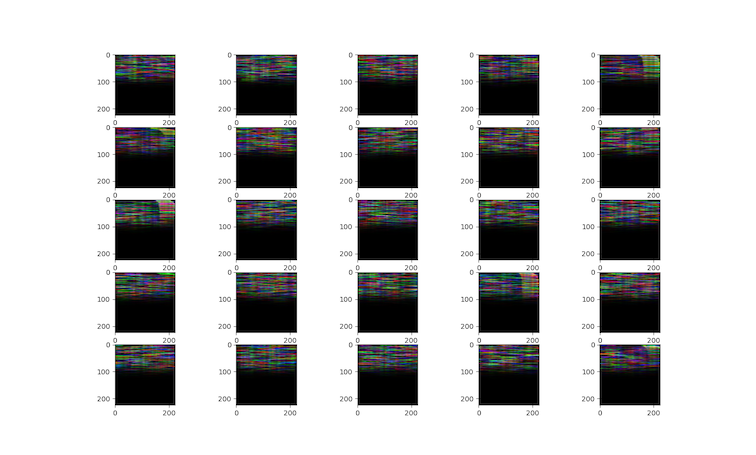

This time we are training on data that looks more legit ! Notice that the spike shape of targets seems familiar, just like the ones presented in the actual data of gravitational wave signals. Although, you can see in the panel of images above this paragraph that when picked randomly, some of the wave signals are very much alike noise signals (no spike). This could be an interesting point to check in the results, can we successfully classify both the obvious spike images and the not so obvious ones ?

### Basic CNN

Ok this time let’s start simple with a trusted weapon, a good old fashion CNN.

For the data pipeline, I used a training set (25% split for validation) structured as a tensorflow Dataset. Preprocessing is done on the fly.

In [ ]:
class CCB3:

    def __init__(self, feature, input_shape, batch_size, kernel_size, learning_rate, train_generator,
                 validation_generator, epochs):
        self.feature = feature
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.epochs = epochs
        self.model = self._build()

    def _build(self):
        input_layer = Input(shape=self.input_shape, name=self.feature, batch_size=self.batch_size)

        conv_1_layer = Conv2D(filters=16, kernel_size=self.kernel_size, activation='relu')(input_layer)
        mp_1_layer = MaxPooling2D(pool_size=2)(conv_1_layer)

        conv_2_layer = Conv2D(filters=32, kernel_size=self.kernel_size, activation='relu')(mp_1_layer)
        mp_2_layer = MaxPooling2D(pool_size=2)(conv_2_layer)

        conv_3_layer = Conv2D(filters=64, kernel_size=self.kernel_size, activation='relu')(mp_2_layer)
        mp_3_layer = MaxPooling2D(pool_size=2)(conv_3_layer)

        flatten_layer = Flatten()(mp_3_layer)
        dense_1_layer = Dense(units=512, activation='relu')(flatten_layer)
        dense_2_layer = Dense(units=64, activation='relu')(dense_1_layer)

        output_layer = Dense(units=1, activation='sigmoid')(dense_2_layer)

        model = Model(input_layer, output_layer)
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

        return model

    def fit(self):
        history = self.model.fit(self.train_generator, epochs=self.epochs, validation_data=self.validation_generator)
        return history

    def save(self, name: str):
        self.model.save(name)

In [ ]:
# --------------- PIPELINE --------------------

all_labels = pd.read_csv(labels_path)
files_ids = all_labels['id']
labels = all_labels['target'].astype('int8').values
x_train, x_val, y_train, y_val = train_test_split(files_ids, labels, random_state=42, stratify=labels)
x_train = x_train.apply(lambda x: DATA_PATH + '/{}/{}/{}/{}.npy'.format(x[0], x[1], x[2], x))
x_val = x_val.apply(lambda x: DATA_PATH + '/{}/{}/{}/{}.npy'.format(x[0], x[1], x[2], x))

training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
training_dataset = training_dataset.map(preprocess, num_parallel_calls=8)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.prefetch(8)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

#### Results

Confusion matrix

[53223 16794]

[28808 41175]

* True Positive: 41175 -> 29.410714285714285%
* True Negative: 53223 -> 38.01642857142858%
* False Positive: 16794 -> 11.995714285714286%
* False Negative: 28808 -> 20.577142857142857%


**Accuracy** = 67.43%

**Precision** =  71.03%

**Recall** = 58.84%

### Pre-trained CNN

I did test both Resnet and EfficientNet, but did not notice a significant difference between their respective results.

In [ ]:
class CCB5:

    def __init__(self, feature, input_shape, batch_size, kernel_size, learning_rate, train_generator,
                 validation_generator, epochs):
        self.feature = feature
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.epochs = epochs
        self.model = self._build()

    def _build(self):
        input_layer = Input(shape=self.input_shape, name=self.feature, batch_size=self.batch_size)

        conv_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=self.input_shape)(input_layer)
        conv_base.trainable = False
        gapl = GlobalAveragePooling2D()(conv_base)
        output_layer = Dense(units=1, activation='sigmoid')(gapl)

        model = Model(input_layer, output_layer)
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

        return model

    def fit(self):
        history = self.model.fit(self.train_generator, epochs=self.epochs, validation_data=self.validation_generator)
        return history

    def save(self, name: str):
        self.model.save(name)

    def predict(self):
        predictions = self.model.predict(self.validation_generator)
        return predictions

#### Results

Confusion matrix

[69813   204]

[56291 13692]
 
* True Positive: 13692 -> 9.78%
* True Negative: 69813 -> 49.86642857142857%
* False Positive: 204 -> 0.1457142857142857%
* False Negative: 56291 -> 40.207857142857144%


**Accuracy** = 59.65%

**Precision** = 98.53%

**Recall** = 19.56%

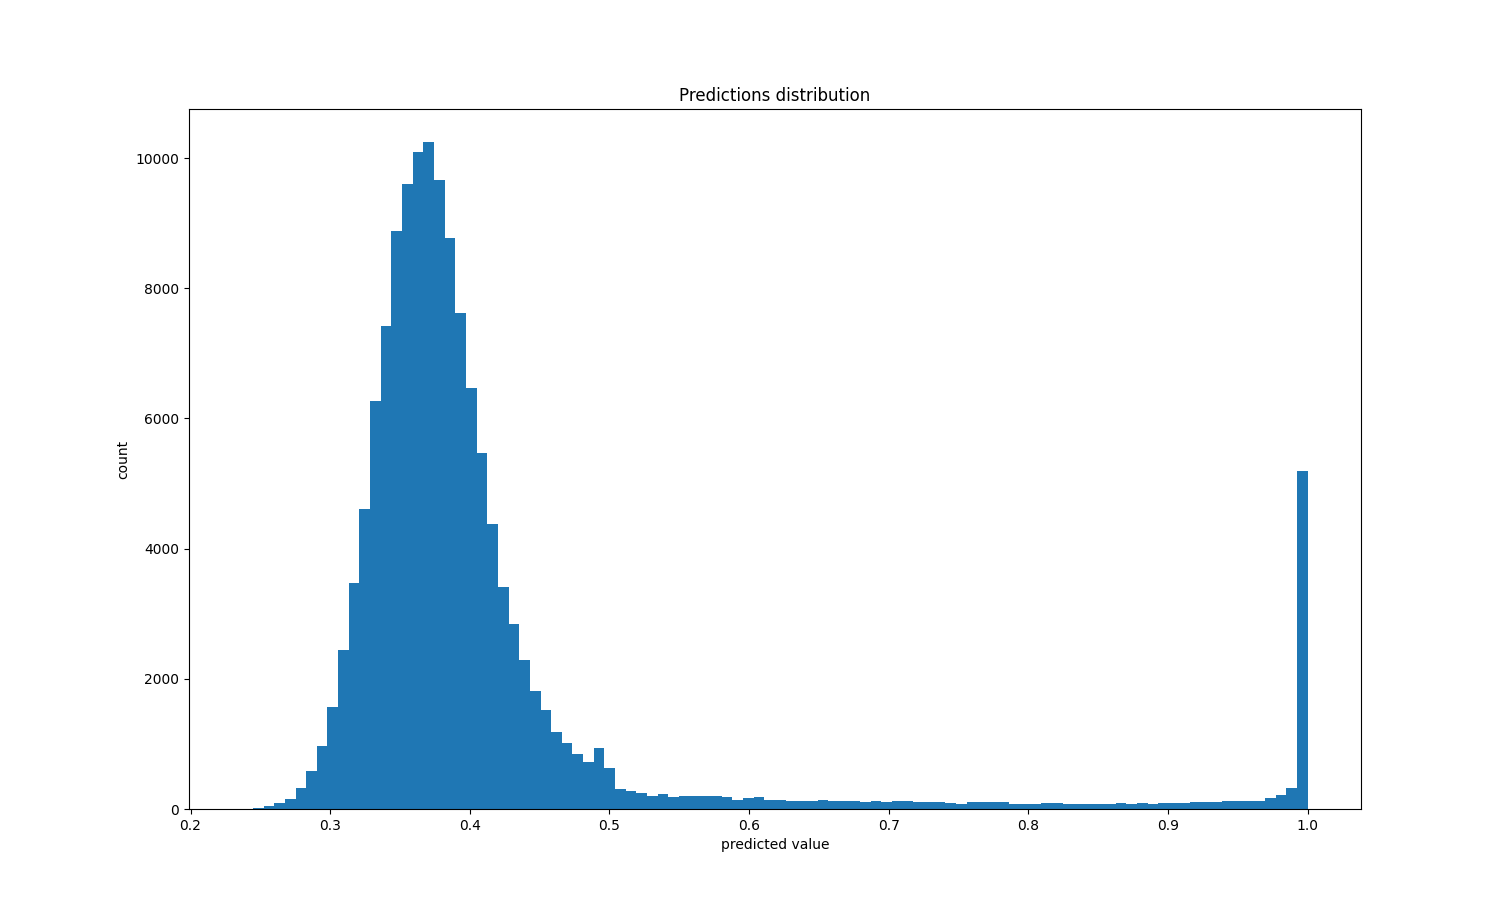

Accuracy is not as high as the basic plain CNN, but I did not optimize the trained layers. I could have also used a GlobalAveragePool layer from the Keras library instead. As for the training result, we obtained an extremely selective model, with almost a perfect precision, but always with the corresponding tradeoff on False Negative that comes with it.

### Predictions similarity

Also I want to check if both models were performant on the same inputs or if they learned different features. In the second scenario, adding an Ensembling step after training these type of models could further improve the results.

*-- code below --*

In [ ]:
def similarity_col(a, b):
    arr_a = np.array(a)
    arr_b = np.array(b)
    similarity_count = {
        'TP': 0,
        'TN': 0,
        'FP': 0,
        'FN': 0
    }
    for elem_a, elem_b in zip(arr_a, arr_b):
        if elem_a == elem_b == 'TP':
            similarity_count['TP'] += 1
        elif elem_a == elem_b == 'TN':
            similarity_count['TN'] += 1
        elif elem_a == elem_b == 'FP':
            similarity_count['FP'] += 1
        elif elem_a == elem_b == 'FN':
            similarity_count['FN'] += 1
    return similarity_count


def compare_models(name_1: str, name_2: str):
    data, paths, labels, model_1 = load_model_and_data(name_1)
    _, _, _, model_2 = load_model_and_data(name_2)

    # get predictions and predictions labels for both models
    predictions_1 = model_1.predict(data)
    predictions_2 = model_2.predict(data)
    predictions_labels_1 = [1 if p > 0.5 else 0 for p in predictions_1]
    predictions_labels_2 = [1 if p > 0.5 else 0 for p in predictions_2]

    # get complete labeled dataframe for both models
    dataframe_1 = label_df_confusion_matrix(predictions_labels_1, predictions_1, labels, paths)
    print(np.unique(np.asarray(dataframe_1['cm']), return_counts=True))
    dataframe_2 = label_df_confusion_matrix(predictions_labels_2, predictions_2, labels, paths)
    print(np.unique(np.asarray(dataframe_2['cm']), return_counts=True))

    # compare similarity of both dataframes regarding TP, TN, FP, FN
    similarity = similarity_col(dataframe_1['cm'], dataframe_2['cm'])
    for key, value in similarity.items():
        print('{}: {}'.format(key, value))

##### Results interpretation


For the basic CNN we have the following:
* FN : 28808
* FP : 16794
* TN : 53223
* TP : 41175

And for the pretrained Convnet:
* FN : 56291
* FP : 204
* TN : 69813
* TP : 13692

Similarity counts of the predictions for each category:
* TP: 13673
* TN: 53209
* FP: 190
* FN: 28789

Which means that both networks detected the same conclusive features to classify target waves (almost 100% of the pretrained convnet true positives are matched by the basic CNN), but other features used by the CNN are not efficient enough (tradeoff with false positives).

# Challenging the data again

Can we improve the data again ? Obviously yes (see, I learned my lesson), so let’s try it !

### True Positives overview

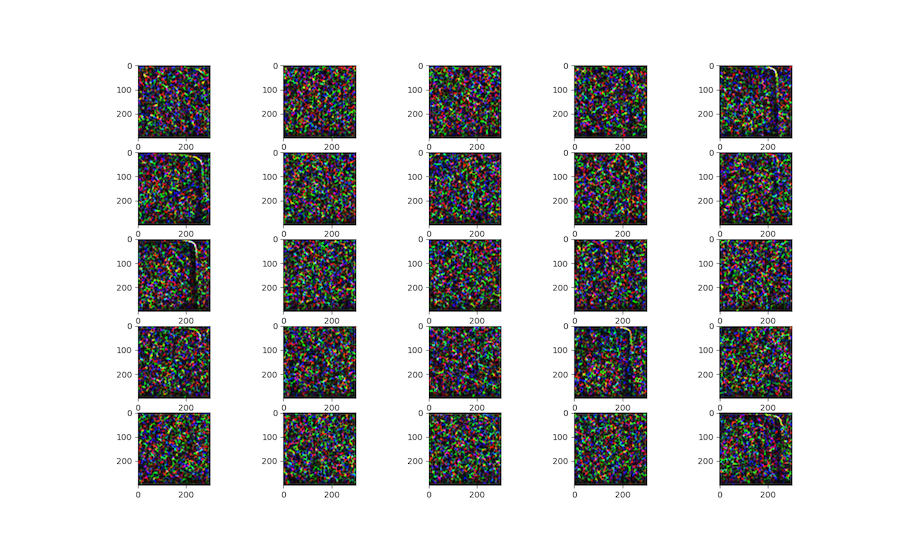

### What did I do differently ?

* Windowing: tukey window is recommended in the original paper as well as in various other notebooks of the competition.  I used it to replace the hanning window in the signal preprocessing.
* Frequencies: I extended the bandpass filter from [35: 350] Hz to [20: 500] Hz in order to take more information in the learning process. Also I activated a window on the segments spectrum computations.
* Image (resolution, dimensions): Finally I modified the spectrum computation function to have a higher frequency/time resolution on the final images. I also chose a larger image (from 112x112 to 150x150 pixels). The objective was to capture more information for the model to train better.

### Basic CNN

epoch 1
***
*2100/2100 [==============================] - ETA: 0s - loss: 0.5496 - acc: 0.70032022-04-19 23:35:23.004577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.*

*2100/2100 [==============================] - 12927s 6s/step - loss: 0.5496 - acc: 0.7003 - val_loss: 0.5243 - val_acc: 0.7220*
***
epoch 2
***
*2100/2100 [==============================] - ETA: 0s - loss: 0.5206 - acc: 0.72392022-04-20 22:43:13.922581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.*

*2100/2100 [==============================] - 11828s 6s/step - loss: 0.5206 - acc: 0.7239 - val_loss: 0.5202 - val_acc: 0.7255*
***
There does not seem to have a real interest to push training further after the second epoch.

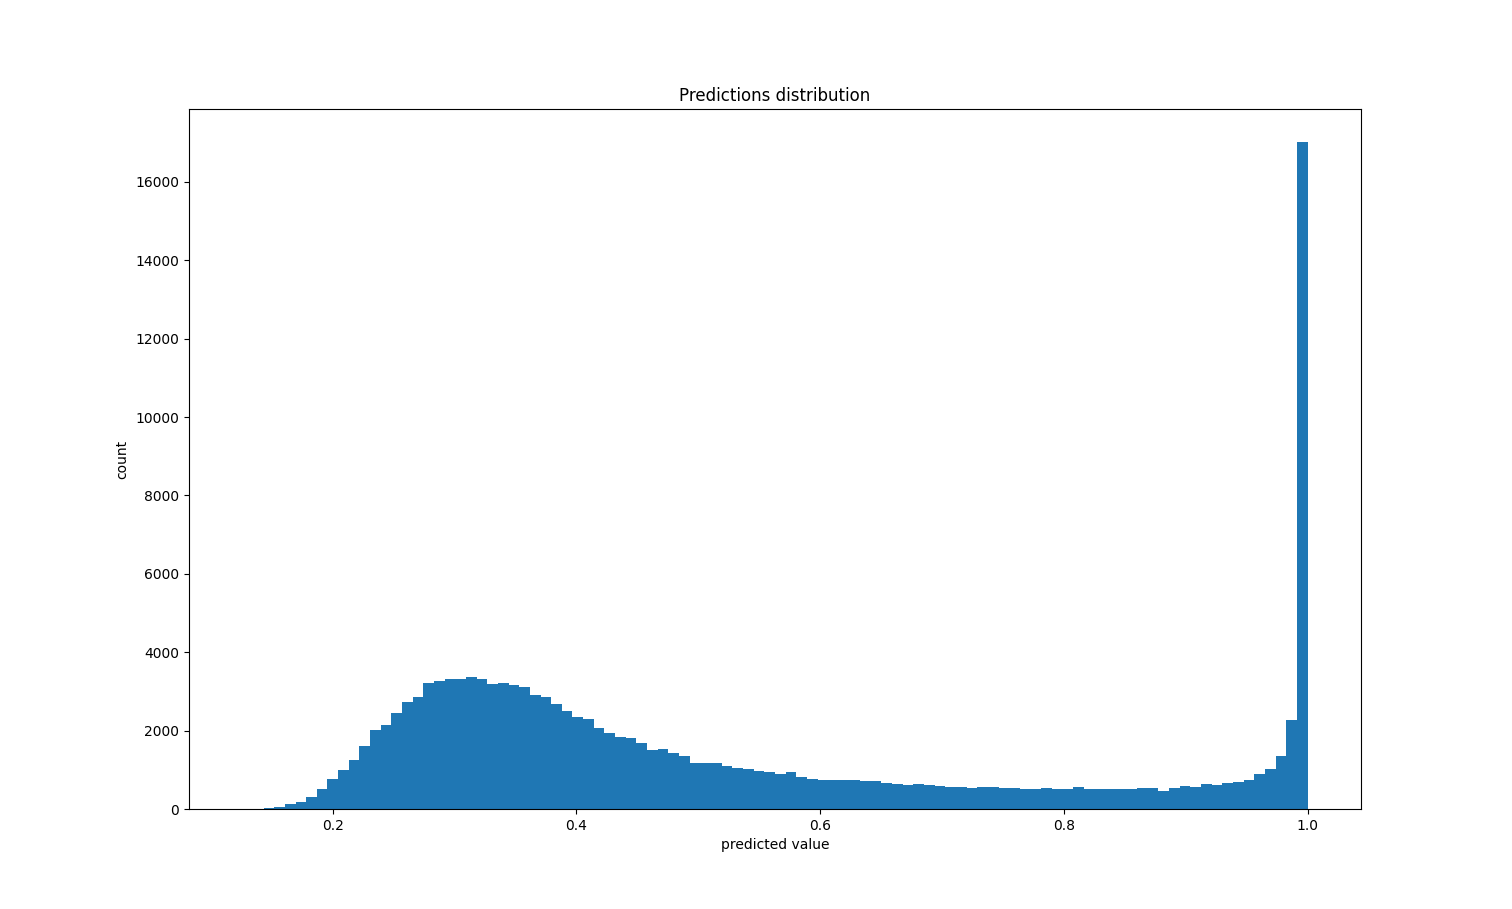

#### Results

Confusion matrix

[56864 13153]

[25277 44706]

* True Positive: 44706 -> 31.93285714285714%
* True Negative: 56864 -> 40.61714285714286%
* False Positive: 13153 -> 9.395000000000001%
* False Negative: 25277 -> 18.055%

**Accuracy** = 72.55%

**Precision** = 77.27%

**Recall** = 63.88%

### Pre-trained CNN

This time let’s show you the results for the Resnet50v2. 

epoch 1
***
*2100/2100 [==============================] - ETA: 0s - loss: 0.5263 - acc: 0.71912022-04-22 20:41:52.003715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.*

*2100/2100 [==============================] - 12114s 6s/step - loss: 0.5263 - acc: 0.7191 - val_loss: 0.5200 - val_acc: 0.7275*
***

**Accuracy** = 72.75%

As we are getting roughly the same score as the plain CNN model, I decided not to continue training based on the assumption that results will not likely improve much.

**Were the updates successful ? With respectively a solid 5% and 13% accuracy increase for each model, I would say yes !**

### Follow up steps

* Use other features extraction methods (such as wavelets) that seem to perform better for our problem.
* Further preprocess data. As we saw on the images, some signals are still drawning in noise. For example use zero padding, fine tune parameters, or even image post-processing.

# Conclusion

That was the most complicated dataset I have worked on so far on Kaggle, and it was definitely not easy. 

I got to learn a lot about signal processing, and also had a very brutal reminder about machine learning methodology.

"Machine learning is not magic, if you feed it crap it will give you the exact same in return." 

I am satisfied with my final results, since I was stuck for a long time. There is yet a great margin for improvement, as top accuracies on this competition go up to over 85%.

# Submission

In [ ]:
# --------------- SUBMISSION --------------------
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

def prep_submission():

    # Load trained model
    model = load_model('../input/g2net-model/ccb3_4/ccb3_4')
    
    # Calculate predictions in batches
    pred_batch = 22600

    for i in range(10):

        submission_files_ids = sample_submission['id'][i*pred_batch:(i+1)*pred_batch]
        x_test = submission_files_ids.apply(lambda x: submission_data_path + '/{}/{}/{}/{}.npy'.format(x[0], x[1], x[2], x))

        test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
        test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        test_dataset = test_dataset.batch(batch_size)
        test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

        partial_predictions = model.predict(test_dataset, verbose=1)
        np.save('partial_submission_{}'.format(i), partial_predictions)

In [ ]:
# Concatenate all predictions
sample_submission_dir = '../input/g2netpartialsubmission'
predictions = None
for sample_submission_path in os.listdir(sample_submission_dir):
    sample_sub = np.load(os.path.join(sample_submission_dir, sample_submission_path))
    if predictions is None:
        predictions = sample_sub
    else:
        predictions = np.concatenate((predictions, sample_sub), axis=None)

# Make submission dataframe
submission = pd.DataFrame({'id': sample_submission['id'], 'target': predictions})

In [ ]:
# Submit
submission.to_csv('./submission.csv', index= False)